In [1]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')

    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews

    !pip install joypy

    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"
    root_path = "/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import gc
gc.collect()  #

import datetime
import gc
import pandas as pd
import joypy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision.datasets as datasets

from Zamuro_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 
from Modules.Clustering_Utils_Zamuro import plot_silhouette
from Modules.Clustering_Utils_Zamuro import plot_centroids
from Modules.Clustering_Utils_Zamuro import ClusteringResults

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datetime import timedelta

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import pacmap

import warnings
warnings.filterwarnings("ignore")


import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/dist

In [3]:
model_type = "AE"
identifier = "batch_size_14_num_hiddens_64_"
day = 4
hour = 9
date_format = f"day_{day}_hour_{hour}"

model_name = f"{root}/Zamuro/temporal_zamuro/models/log_standarization_model_epochs_10/model_{model_type}_{identifier}_{date_format}_final.pth"
model = AE(num_hiddens=64).to(device)
model.load_state_dict(torch.load(f'{model_name}', map_location=torch.device('cpu')))


filters = {"rain_FI": "NO"}
dataset = SoundscapeData('media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/',
                         dataframe_path="Complementary_Files/zamuro_audios.csv",
                         audio_length=12, ext="wav",
                         win_length=1028, filters=filters)

test_loader = DataLoader(dataset, batch_size=100)
iterator = iter(test_loader)
testing = TestModel(model, iterator, device=torch.device("cuda"))

/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/


In [4]:
audios = pd.read_csv(f"Complementary_Files/zamuro_audios_complete.csv", index_col=0)
recorders = pd.read_csv(f"Complementary_Files/zamuro_recorders_satelites.csv", index_col=0)
df_ae = pd.read_csv(f"temporal_zamuro/Features/New_df_ae_unflat.csv")
X = np.asarray(df_ae.loc[:,"0":"25919"])
X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
X = np.mean(X, axis=1)
print(X.shape)

(53275, 5184)


day=5
df_day = df_ae[df_ae['day'].isin([day])]
X_day = np.asarray(df_day.loc[:,"0":"5183"])

Normalizer_ = Normalizer().fit(X_day)
X = Normalizer_.transform(X_day)

X.shape

In [5]:
df_ae.set_index("y", inplace=True)
df_ae = df_ae.join(audios[['longitud_IG', 'latitude_IG']], how='left')

## Conectividad en audios por días

In [ ]:
import pacmap
import networkx as nx
import matplotlib.pyplot as plt
import mplcyberpunk  # Estilo visual mejorado
from sklearn.datasets import make_blobs
from scipy.spatial import distance_matrix
import time

days = list(set(df_ae["day"]))

for day in days:
    df_day = df_ae[df_ae['day'].isin([day])]
    X_day = np.asarray(df_day.loc[:,"0":"25919"])
    X_day = np.reshape(X_day, [X_day.shape[0], 5, X_day.shape[1]//5])
    X_day = np.mean(X_day, axis=1)

    Normalizer_ = Normalizer().fit(X_day)
    X = Normalizer_.transform(X_day)

    # 🔹 Aplicar PacMAP para reducir a 2D

    print("Computing PacMAP features")
    start_time = time.time()
    pacmap_reducer = pacmap.PaCMAP(n_components=2, n_neighbors=75, MN_ratio=1, FP_ratio=20)
    X_pacmap = pacmap_reducer.fit_transform(X)
    print(f"PacMAP completed in {time.time() - start_time:.2f} secs.")

    plt.figure()
    plt.scatter(X_pacmap[:,0], X_pacmap[:,1], s=1, alpha=1)
    plt.title("PacMAP Projection")
    plt.show()

    # 🔹 Construir matriz de distancias de Hamming en el espacio reducido
    print("Computing Hamming distance matrix in PacMAP space...")
    start_time = time.time()
    distance_mat = distance_matrix(X_pacmap, X_pacmap, p=1)  # Distancia de Hamming en 2D
    print(f"Hamming distance computed in {time.time() - start_time:.2f} secs.")

    # 🔹 Crear grafo basado en distancia de Hamming en el espacio PacMAP
    print("Computing Graph...")
    G = nx.Graph()
    threshold = np.percentile(distance_mat, 5)  # Tomar un umbral bajo para conexiones cercanas
    graph_edges = []
    for i in range(len(X_pacmap)):
        for j in range(i + 1, len(X_pacmap)):
            if distance_mat[i, j] < threshold:
                G.add_edge(i, j)
                graph_edges.append((i, j))
    print(f"Graph computed with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    # 🔹 Usar las coordenadas de PacMAP como layout
    print("Applying PacMAP-Based Layout...")
    start_time = time.time()
    pos_pacmap = {i: X_pacmap[i] for i in range(len(X_pacmap))}  # Usa PacMAP como layout
    print(f"PacMAP Layout completed in {time.time() - start_time:.2f} secs.")

    # 🔹 Graficar con mejor estilo
    plt.style.use("seaborn-whitegrid")  # Activar el estilo seaborn-whitegrid
    fig, ax = plt.subplots(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos_pacmap, node_size=5, node_color='black', alpha=0.8)
    nx.draw_networkx_edges(G, pos_pacmap, edgelist=graph_edges, width=0.3, edge_color="red", alpha=0.3)

    print("Graph plotted")

    # 🔹 Efectos visuales
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.title("Hamming Layout Edge Bundling (PacMAP)")
    plt.xlabel("PacMAP 1")
    plt.ylabel("PacMAP 2")
    plt.tight_layout()
    plt.savefig(f"temporal_zamuro/zamuro_connectivity_results/Days_Results/AE/PacMAP/connectivity_{str(day)}")
    plt.show()

## Conectividad en Grabadoras

Muestreando datos...
Calculando características acústicas...
Computando PacMAP...
PacMAP completado
Extrayendo datos de sampled_df_ae...
Número de grabadoras: 90
Extrayendo coordenadas de grabadoras...
Construyendo grafo de conectividad entre audios...
Grafo de audios: 1066 nodos, 31694 conexiones


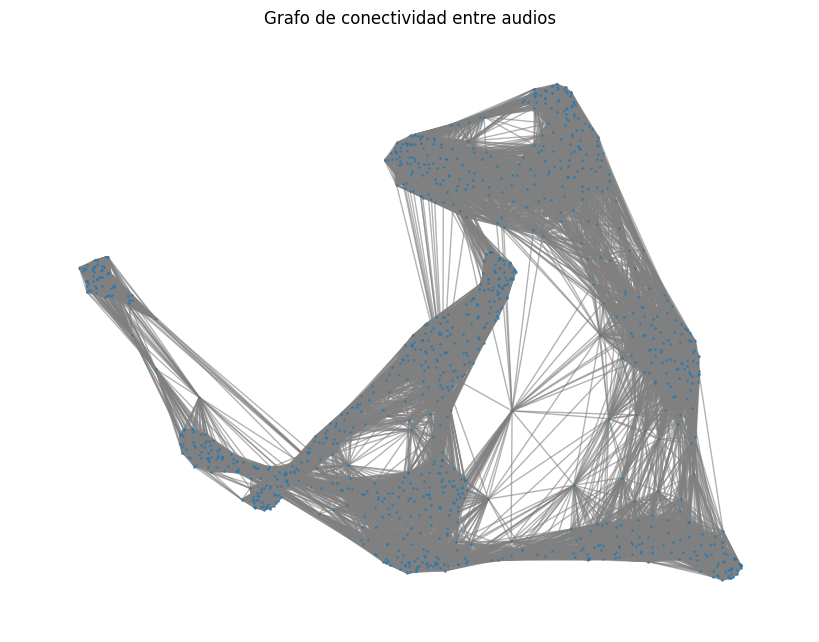

Construyendo grafo de grabadoras basado en características de audio...
Definiendo función de atención...
Normalizando pesos de atención con Softmax probabilístico...
Creando el grafo de grabadoras con pesos de atención probabilísticos...
Creando el grafo de grabadoras con pesos de atención...
Grafo de grabadoras: 90 nodos, 3565 conexiones
Aplicando Hammer Edge Bundling...


<AxesSubplot: xlabel='x'>

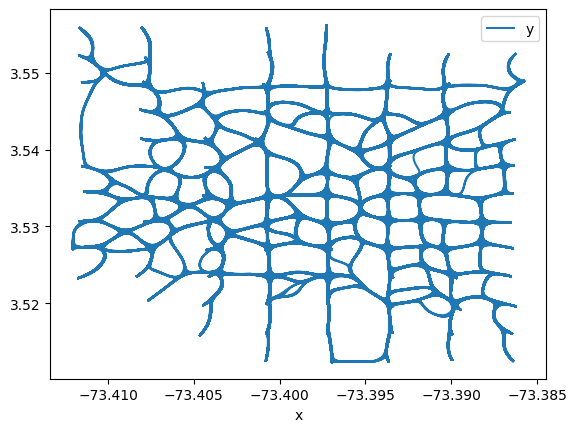

In [54]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point, LineString
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler
from datashader.bundling import hammer_bundle
from scipy.special import softmax

print("Muestreando datos...")
sampled_df_ae = df_ae.sample(frac=0.02, random_state=42)  # Tomar el 5% de los datos para prueba rápida
# sampled_df_ae = df_ae  # Tomar el 5% de los datos para prueba rápida


print("Calculando características acústicas...")
X = np.asarray(sampled_df_ae.loc[:, "0":"25919"])
X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
X = np.mean(X, axis=1)

print("Computando PacMAP...")
pacmap_reducer = pacmap.PaCMAP(n_components=2, n_neighbors=75, MN_ratio=1, FP_ratio=20)
X_pacmap = pacmap_reducer.fit_transform(X)
print("PacMAP completado")




Visualizando grafo de grabadoras...


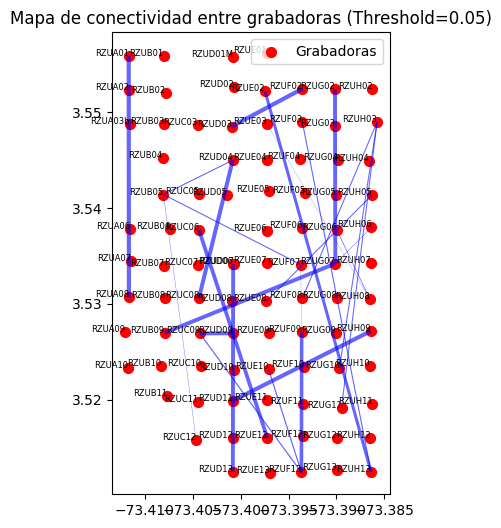

In [112]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point, LineString
from sklearn.neighbors import kneighbors_graph
from scipy.special import softmax

print("Extrayendo datos de sampled_df_ae...")
grabadoras = sampled_df_ae['location'].unique()
n_grabadoras = len(grabadoras)
location_map = {loc: i for i, loc in enumerate(grabadoras)}
sampled_df_ae['grabadora_id'] = sampled_df_ae['location'].map(location_map)

print("Extrayendo coordenadas de grabadoras...")
coordenadas_grabadoras = {
    location_map[loc]: Point(sampled_df_ae[sampled_df_ae['location'] == loc]["longitud_IG"].mean(), 
                             sampled_df_ae[sampled_df_ae['location'] == loc]["latitude_IG"].mean())
    for loc in grabadoras
}

print("Construyendo grafo de conectividad entre audios...")
X_audio = X_pacmap
audio_graph = kneighbors_graph(X_audio, n_neighbors=50, mode="connectivity", include_self=False)
G_audio = nx.from_scipy_sparse_array(audio_graph)

print("Construyendo grafo de grabadoras basado en conexiones de audio...")
G_grabadoras = nx.Graph()
for i in range(n_grabadoras):
    G_grabadoras.add_node(i, pos=coordenadas_grabadoras[i])

print("Definiendo función de atención basada en conexiones entre grabadoras...")
audio_counts = {}
for i, j in G_audio.edges():
    g1, g2 = sampled_df_ae.iloc[i]['grabadora_id'], sampled_df_ae.iloc[j]['grabadora_id']
    if g1 != g2:
        audio_counts[(g1, g2)] = audio_counts.get((g1, g2), 0) + 1

# Agregar conexiones al grafo de grabadoras
for (g1, g2), count in audio_counts.items():
    G_grabadoras.add_edge(g1, g2, weight=count)

print("Aplicando Softmax por grabadora...")
# Diccionario para almacenar los pesos normalizados por cada grabadora
normalized_weights = {}

# Aplicar softmax a las conexiones de cada grabadora individualmente
for grabadora in G_grabadoras.nodes():
    vecinos = list(G_grabadoras[grabadora])
    if not vecinos:
        continue  # Si no tiene conexiones, continuar

    # Obtener los pesos originales de las conexiones
    pesos = np.array([G_grabadoras[grabadora][v]['weight'] for v in vecinos], dtype=np.float32)
    
    # Aplicar softmax a los pesos de esta grabadora
    pesos_softmax = softmax(pesos)

    # Asignar los pesos normalizados al grafo
    for idx, v in enumerate(vecinos):
        normalized_weights[(grabadora, v)] = pesos_softmax[idx]

# Aplicar umbral y actualizar el grafo
threshold = 0.05  # Ajusta según necesidad
edges_to_remove = []

for (g1, g2), weight in normalized_weights.items():
    if weight < threshold:
        edges_to_remove.append((g1, g2))  # Marcar para eliminar
    else:
        G_grabadoras[g1][g2]['weight'] = weight  # Asignar peso normalizado

# Eliminar conexiones débiles
G_grabadoras.remove_edges_from(edges_to_remove)

print(f"Grafo de grabadoras actualizado: {G_grabadoras.number_of_nodes()} nodos, {G_grabadoras.number_of_edges()} conexiones después del umbral.")

print("Visualizando grafo de grabadoras...")
fig, ax = plt.subplots(figsize=(10, 6))

# Crear GeoDataFrame para visualizar las grabadoras
geo_df = gpd.GeoDataFrame({"grabadora": list(coordenadas_grabadoras.keys()), "geometry": list(coordenadas_grabadoras.values())})
geo_df.plot(ax=ax, color='red', markersize=50, label="Grabadoras")

# Dibujar las conexiones entre grabadoras
for i, j in G_grabadoras.edges():
    if i in coordenadas_grabadoras and j in coordenadas_grabadoras:
        line = LineString([coordenadas_grabadoras[i], coordenadas_grabadoras[j]])
        gpd.GeoSeries([line]).plot(ax=ax, color='blue', linewidth=G_grabadoras[i][j]['weight'] * 3, alpha=0.6)

# Obtener etiquetas de las grabadoras desde sampled_df_ae
labels = sampled_df_ae.set_index("grabadora_id")["location"].to_dict()

# Dibujar etiquetas sobre los nodos en el grafo
for grabadora_id, point in coordenadas_grabadoras.items():
    ax.text(point.x, point.y, labels[grabadora_id], fontsize=5, ha='right', color='black')

ax.set_title(f"Mapa de conectividad entre grabadoras (Threshold={threshold})")
plt.legend()
plt.show()


Aplicando Hammer Edge Bundling...


<AxesSubplot: xlabel='x'>

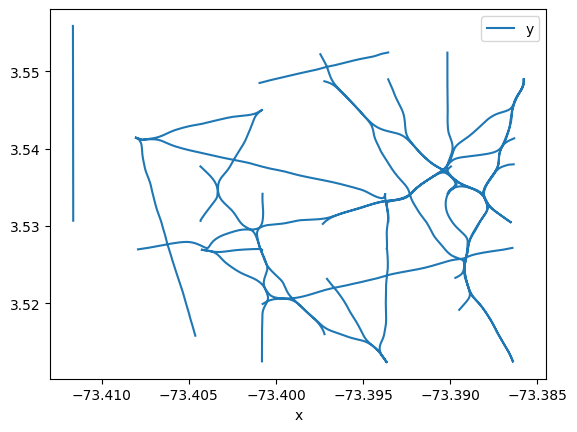

In [113]:
print("Aplicando Hammer Edge Bundling...")
edge_list = [(u, v, G_grabadoras.edges[u, v]['weight']) for u, v in G_grabadoras.edges()]
node_positions = {n: (p.x, p.y) for n, p in coordenadas_grabadoras.items()}
import numpy.lib.recfunctions as rfn

# Convertir node_positions_array a un array estructurado con nombres de campo
node_positions_array = np.array(
    list(node_positions.values()), 
    dtype=[('x', np.float32), ('y', np.float32)]
)
edge_indices = np.array([(u, v) for u, v in G_grabadoras.edges()])

# Convertir node_positions a un DataFrame
node_positions_df = pd.DataFrame.from_dict(
    node_positions, orient="index", columns=["x", "y"]
)
node_positions_df.index.name = "node_id"  # Asegurar que el índice tenga un nombre

# Convertir edge_indices a un DataFrame
edge_indices_df = pd.DataFrame(
    [(u, v) for u, v in G_grabadoras.edges()], columns=["source", "target"]
)

bundled_edges = hammer_bundle(node_positions_df, edge_indices_df)
# Asegurarnos de que bundled_edges sea una lista de listas de puntos
bundled_edges.plot(x="x", y="y")

## Conectividad en grabadoras por días

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point, LineString
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler
from datashader.bundling import hammer_bundle

day = 8

print("Muestreando datos...")
# sampled_df_ae = df_ae.sample(frac=0.02, random_state=42)  # Tomar el 5% de los datos para prueba rápida
df_day = df_ae[df_ae['day'].isin([day])]


print("Calculando características acústicas...")
X_day = np.asarray(df_day.loc[:,"0":"25919"])
X_day = np.reshape(X_day, [X_day.shape[0], 5, X_day.shape[1]//5])
X_day = np.mean(X_day, axis=1)


print("Computando PacMAP...")
pacmap_reducer = pacmap.PaCMAP(n_components=2, n_neighbors=75, MN_ratio=1, FP_ratio=20)
X_pacmap = pacmap_reducer.fit_transform(X_day)
print("PacMAP completado")

print("Extrayendo datos de sampled_df_ae...")
grabadoras = sampled_df_ae['location'].unique()
n_grabadoras = len(grabadoras)
location_map = {loc: i for i, loc in enumerate(grabadoras)}
sampled_df_ae['grabadora_id'] = sampled_df_ae['location'].map(location_map)

print("Extrayendo coordenadas de grabadoras...")
coordenadas_grabadoras = {
    location_map[loc]: Point(sampled_df_ae[sampled_df_ae['location'] == loc]["longitud_IG"].mean(), 
                             sampled_df_ae[sampled_df_ae['location'] == loc]["latitude_IG"].mean())
    for loc in grabadoras
}

print("Construyendo grafo de conectividad entre audios...")
X_audio = X_pacmap
audio_graph = kneighbors_graph(X_audio, n_neighbors=50, mode="connectivity", include_self=False)
G_audio = nx.from_scipy_sparse_array(audio_graph)

print("Construyendo grafo de grabadoras basado en conexiones de audio...")
G_grabadoras = nx.Graph()
for i in range(n_grabadoras):
    G_grabadoras.add_node(i, pos=coordenadas_grabadoras[i])

print("Definiendo función de atención basada en conexiones entre grabadoras...")
audio_counts = {}
for i, j in G_audio.edges():
    g1, g2 = sampled_df_ae.iloc[i]['grabadora_id'], sampled_df_ae.iloc[j]['grabadora_id']
    if g1 != g2:
        audio_counts[(g1, g2)] = audio_counts.get((g1, g2), 0) + 1

# Agregar conexiones al grafo de grabadoras
for (g1, g2), count in audio_counts.items():
    G_grabadoras.add_edge(g1, g2, weight=count)

print("Aplicando Softmax por grabadora...")
# Diccionario para almacenar los pesos normalizados por cada grabadora
normalized_weights = {}

# Aplicar softmax a las conexiones de cada grabadora individualmente
for grabadora in G_grabadoras.nodes():
    vecinos = list(G_grabadoras[grabadora])
    if not vecinos:
        continue  # Si no tiene conexiones, continuar

    # Obtener los pesos originales de las conexiones
    pesos = np.array([G_grabadoras[grabadora][v]['weight'] for v in vecinos], dtype=np.float32)
    
    # Aplicar softmax a los pesos de esta grabadora
    pesos_softmax = softmax(pesos)

    # Asignar los pesos normalizados al grafo
    for idx, v in enumerate(vecinos):
        normalized_weights[(grabadora, v)] = pesos_softmax[idx]

# Aplicar umbral y actualizar el grafo
threshold = 0.05  # Ajusta según necesidad
edges_to_remove = []

for (g1, g2), weight in normalized_weights.items():
    if weight < threshold:
        edges_to_remove.append((g1, g2))  # Marcar para eliminar
    else:
        G_grabadoras[g1][g2]['weight'] = weight  # Asignar peso normalizado

# Eliminar conexiones débiles
G_grabadoras.remove_edges_from(edges_to_remove)

print(f"Grafo de grabadoras actualizado: {G_grabadoras.number_of_nodes()} nodos, {G_grabadoras.number_of_edges()} conexiones después del umbral.")

print("Visualizando grafo de grabadoras...")
fig, ax = plt.subplots(figsize=(10, 6))

# Crear GeoDataFrame para visualizar las grabadoras
geo_df = gpd.GeoDataFrame({"grabadora": list(coordenadas_grabadoras.keys()), "geometry": list(coordenadas_grabadoras.values())})
geo_df.plot(ax=ax, color='red', markersize=50, label="Grabadoras")

# Dibujar las conexiones entre grabadoras
for i, j in G_grabadoras.edges():
    if i in coordenadas_grabadoras and j in coordenadas_grabadoras:
        line = LineString([coordenadas_grabadoras[i], coordenadas_grabadoras[j]])
        gpd.GeoSeries([line]).plot(ax=ax, color='blue', linewidth=G_grabadoras[i][j]['weight'] * 3, alpha=0.6)

# Obtener etiquetas de las grabadoras desde sampled_df_ae
labels = sampled_df_ae.set_index("grabadora_id")["location"].to_dict()

# Dibujar etiquetas sobre los nodos en el grafo
for grabadora_id, point in coordenadas_grabadoras.items():
    ax.text(point.x, point.y, labels[grabadora_id], fontsize=5, ha='right', color='black')

ax.set_title(f"Mapa de conectividad entre grabadoras (Threshold={threshold})")
plt.legend()
plt.show()

Muestreando datos...
Calculando características acústicas...
Computando PacMAP...
PacMAP completado
Extrayendo datos de sampled_df_ae...
Extrayendo coordenadas de grabadoras...
Construyendo grafo de conectividad entre audios...


KeyboardInterrupt: 

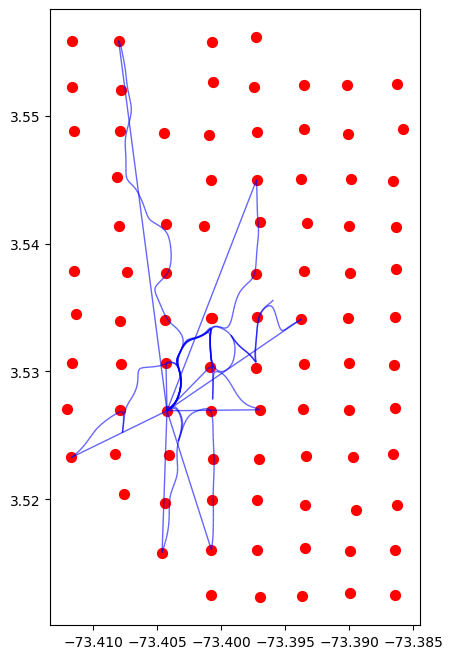

In [45]:
valid_edges = []

# Revisamos si los elementos son puntos individuales
if all(isinstance(line, list) and len(line) == 2 and all(isinstance(coord, (int, float)) for coord in line) for line in bundled_edges_list):
    # Convertimos los puntos en pares consecutivos para formar líneas
    bundled_edges_list_fixed = [(bundled_edges_list[i], bundled_edges_list[i + 1]) for i in range(len(bundled_edges_list) - 1)]
else:
    # Si ya están bien formateados, los dejamos igual
    bundled_edges_list_fixed = bundled_edges_list

# Ahora aplicamos la limpieza normal
for line in bundled_edges_list_fixed:
    clean_line = [(x, y) for x, y in line if not (np.isnan(x) or np.isnan(y))]
    if len(clean_line) > 1:
        valid_edges.append(clean_line)

# Graficamos
fig, ax = plt.subplots(figsize=(10, 8))
geo_df.plot(ax=ax, color='red', markersize=50, label="Grabadoras")

for line in valid_edges:
    gpd.GeoSeries([LineString(line)]).plot(ax=ax, color='blue', linewidth=1, alpha=0.6)

ax.set_title("Mapa de conectividad entre grabadoras con Hammer Edge Bundling")
plt.legend()
plt.show()



In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point, LineString
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler
from datashader.bundling import hammer_bundle
from scipy.interpolate import splprep, splev

def smooth_curve(points, smooth_factor=0.5, num_points=100):
    points = np.array(points)
    if points.shape[0] < 3:
        return points  # No se puede suavizar con menos de 3 puntos
    
    tck, u = splprep([points[:, 0], points[:, 1]], s=smooth_factor)
    u_fine = np.linspace(0, 1, num_points)
    smoothed_points = np.array(splev(u_fine, tck)).T
    return smoothed_points

print("Muestreando datos...")
sampled_df_ae = df_ae.sample(frac=0.002, random_state=42)

print("Calculando características acústicas...")
X = np.asarray(sampled_df_ae.loc[:, "0":"25919"])
X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
X = np.mean(X, axis=1)

print("Computando PacMAP...")
pacmap_reducer = pacmap.PaCMAP(n_components=2, n_neighbors=75, MN_ratio=1, FP_ratio=20)
X_pacmap = pacmap_reducer.fit_transform(X)
print("PacMAP completado")

print("Extrayendo datos de sampled_df_ae...")
grabadoras = sampled_df_ae['location'].unique()
n_grabadoras = len(grabadoras)
location_map = {loc: i for i, loc in enumerate(grabadoras)}
sampled_df_ae['grabadora_id'] = sampled_df_ae['location'].map(location_map)
print(f"Número de grabadoras: {n_grabadoras}")

print("Extrayendo coordenadas de grabadoras...")
coordenadas_grabadoras = {
    location_map[loc]: Point(sampled_df_ae[sampled_df_ae['location'] == loc]["longitud_IG"].mean(), 
                             sampled_df_ae[sampled_df_ae['location'] == loc]["latitude_IG"].mean())
    for loc in grabadoras
}

print("Construyendo grafo de conectividad entre audios...")
X_audio = X_pacmap
n_audios = X_audio.shape[0]
audio_graph = kneighbors_graph(X_audio, n_neighbors=15, mode="connectivity", include_self=False)
G_audio = nx.from_scipy_sparse_array(audio_graph)
print(f"Grafo de audios: {G_audio.number_of_nodes()} nodos, {G_audio.number_of_edges()} conexiones")

plt.figure(figsize=(8, 6))
nx.draw(G_audio, node_size=10, edge_color="gray", alpha=0.6, with_labels=False)
plt.title("Grafo de conectividad entre audios")
plt.show()

print("Construyendo grafo de grabadoras basado en características de audio...")
G_grabadoras = nx.Graph()
for i in range(n_grabadoras):
    G_grabadoras.add_node(i, pos=coordenadas_grabadoras[i])

print("Definiendo función de atención basada en conexiones entre grabadoras...")
audio_counts = {}
for i, j in G_audio.edges():
    g1, g2 = sampled_df_ae.iloc[i]['grabadora_id'], sampled_df_ae.iloc[j]['grabadora_id']
    if g1 != g2:
        audio_counts[(g1, g2)] = audio_counts.get((g1, g2), 0) + 1

print("Normalizando pesos de atención...")
keys = list(audio_counts.keys())
values = np.array(list(audio_counts.values()), dtype=np.float32)
if len(values) > 0:
    attention_weights = MinMaxScaler(feature_range=(0.5, 5)).fit_transform(values.reshape(-1, 1)).flatten()
else:
    attention_weights = np.array([])
    

print("Creando el grafo de grabadoras con pesos de atención...")
for idx, (g1, g2) in enumerate(keys):
    G_grabadoras.add_edge(g1, g2, weight=attention_weights[idx])

print(f"Grafo de grabadoras: {G_grabadoras.number_of_nodes()} nodos, {G_grabadoras.number_of_edges()} conexiones")

attention_weights = pd.Series(attention_weights, index=range(len(attention_weights)))
print("Aplicando Hammer Edge Bundling...")
node_positions = {n: (p.x, p.y) for n, p in coordenadas_grabadoras.items()}
node_positions_array = np.array(list(node_positions.values()))
node_index_map = {node: idx for idx, node in enumerate(node_positions.keys())}
edge_indices = np.array([(node_index_map[u], node_index_map[v]) for u, v in G_grabadoras.edges()])

bundled_edges = hammer_bundle(pd.DataFrame(node_positions_array, columns=['x', 'y']), edge_indices)

print("Generando visualización con Hammer Edge Bundling y curvas suavizadas...")
fig, ax = plt.subplots(figsize=(10, 6))
geo_df = gpd.GeoDataFrame({"grabadora": list(coordenadas_grabadoras.keys()), "geometry": list(coordenadas_grabadoras.values())})
geo_df.plot(ax=ax, color='red', markersize=50, label="Grabadoras")

for line in bundled_edges:
    smoothed_line = smooth_curve(line)
    gpd.GeoSeries([LineString(smoothed_line)]).plot(ax=ax, color='blue', linewidth=1, alpha=0.6)

ax.set_title("Mapa de conectividad entre grabadoras con Hammer Edge Bundling")
plt.legend()
plt.show()




Muestreando datos...
Calculando características acústicas...
Computando PacMAP...


In [30]:
type(attention_weights)

numpy.ndarray

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point, LineString
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import splprep, splev

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# Función para suavizar curvas usando Bezier
def smooth_curve(points, smooth_factor=0.5, num_points=100):
    points = np.array(points)
    if points.shape[0] < 3:
        return points  # No se puede suavizar con menos de 3 puntos
    
    tck, u = splprep([points[:, 0], points[:, 1]], s=smooth_factor)
    u_fine = np.linspace(0, 1, num_points)
    smoothed_points = np.array(splev(u_fine, tck)).T
    return smoothed_points

print("Muestreando datos...")
sampled_df_ae = df_ae.sample(frac=0.05, random_state=42)

print("Calculando características acústicas...")
X = np.asarray(sampled_df_ae.loc[:, "0":"25919"])
X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
X = np.mean(X, axis=1)

print("Computando PacMAP...")
pacmap_reducer = pacmap.PaCMAP(n_components=2, n_neighbors=75, MN_ratio=1, FP_ratio=20)
X_pacmap = pacmap_reducer.fit_transform(X)
print("PacMAP completado")

print("Extrayendo datos de sampled_df_ae...")
grabadoras = sampled_df_ae['location'].unique()
n_grabadoras = len(grabadoras)
location_map = {loc: i for i, loc in enumerate(grabadoras)}
sampled_df_ae['grabadora_id'] = sampled_df_ae['location'].map(location_map)
print(f"Número de grabadoras: {n_grabadoras}")

print("Extrayendo coordenadas de grabadoras...")
coordenadas_grabadoras = {
    location_map[loc]: Point(sampled_df_ae[sampled_df_ae['location'] == loc]["longitud_IG"].mean(), 
                             sampled_df_ae[sampled_df_ae['location'] == loc]["latitude_IG"].mean())
    for loc in grabadoras
}

print("Construyendo grafo de conectividad entre audios...")
X_audio = X_pacmap
n_audios = X_audio.shape[0]
audio_graph = kneighbors_graph(X_audio, n_neighbors=15, mode="connectivity", include_self=False)
G_audio = nx.from_scipy_sparse_array(audio_graph)
print(f"Grafo de audios: {G_audio.number_of_nodes()} nodos, {G_audio.number_of_edges()} conexiones")

plt.figure(figsize=(8, 6))
nx.draw(G_audio, node_size=10, edge_color="gray", alpha=0.6, with_labels=False)
plt.title("Grafo de conectividad entre audios")
plt.show()

print("Construyendo grafo de grabadoras basado en características de audio...")
G_grabadoras = nx.Graph()
for i in range(n_grabadoras):
    G_grabadoras.add_node(i, pos=coordenadas_grabadoras[i])

print("Definiendo función de atención basada en conexiones entre grabadoras...")
audio_counts = {}
for i, j in G_audio.edges():
    g1, g2 = sampled_df_ae.iloc[i]['grabadora_id'], sampled_df_ae.iloc[j]['grabadora_id']
    if g1 != g2:
        audio_counts[(g1, g2)] = audio_counts.get((g1, g2), 0) + 1

print("Normalizando pesos de atención con Softmax...")
keys = list(audio_counts.keys())
values = np.array(list(audio_counts.values()), dtype=np.float32)
if len(values) > 0:
    attention_weights = softmax(values) * 4.5 + 0.5  # Escalar a [0.5, 5]
else:
    attention_weights = np.array([])

print("Creando el grafo de grabadoras con pesos de atención...")
for idx, (g1, g2) in enumerate(keys):
    G_grabadoras.add_edge(g1, g2, weight=attention_weights[idx])

print(f"Grafo de grabadoras: {G_grabadoras.number_of_nodes()} nodos, {G_grabadoras.number_of_edges()} conexiones")

print("Generando visualización con Bezier Edge Bundling y curvas suavizadas...")
fig, ax = plt.subplots(figsize=(10, 6))
geo_df = gpd.GeoDataFrame({"grabadora": list(coordenadas_grabadoras.keys()), "geometry": list(coordenadas_grabadoras.values())})
geo_df.plot(ax=ax, color='red', markersize=50, label="Grabadoras")

for i, j in G_grabadoras.edges():
    if i in coordenadas_grabadoras and j in coordenadas_grabadoras:
        line_points = np.array([
            (coordenadas_grabadoras[i].x, coordenadas_grabadoras[i].y),
            ((coordenadas_grabadoras[i].x + coordenadas_grabadoras[j].x) / 2 + np.random.uniform(-0.001, 0.001),
             (coordenadas_grabadoras[i].y + coordenadas_grabadoras[j].y) / 2 + np.random.uniform(-0.001, 0.001)),
            (coordenadas_grabadoras[j].x, coordenadas_grabadoras[j].y)
        ])
        smoothed_line = smooth_curve(line_points)
        gpd.GeoSeries([LineString(smoothed_line)]).plot(ax=ax, color='blue', linewidth=G_grabadoras[i][j]['weight'], alpha=0.6)

ax.set_title("Mapa de conectividad entre grabadoras con Bezier Edge Bundling")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
from shapely.geometry import Point, LineString
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import kneighbors_graph

print("Muestreando datos...")
sampled_df_ae = df_ae.sample(frac=0.01, random_state=42)  # Tomar el 5% de los datos para prueba rápida

print("Calculando características acústicas...")
# 🔹 Extraer características acústicas de la versión muestreada
X = np.asarray(sampled_df_ae.loc[:, "0":"25919"])
X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
X = np.mean(X, axis=1)

print("Computando PacMAP...")
pacmap_reducer = pacmap.PaCMAP(n_components=2, n_neighbors=75, MN_ratio=1, FP_ratio=20)
X_pacmap = pacmap_reducer.fit_transform(X)
print("PacMAP completado")

print("Extrayendo datos de sampled_df_ae...")
grabadoras = sampled_df_ae['location'].unique()
n_grabadoras = len(grabadoras)
location_map = {loc: i for i, loc in enumerate(grabadoras)}
sampled_df_ae['grabadora_id'] = sampled_df_ae['location'].map(location_map)
print(f"Número de grabadoras: {n_grabadoras}")

print("Extrayendo coordenadas de grabadoras...")
coordenadas_grabadoras = {
    location_map[loc]: Point(sampled_df_ae[sampled_df_ae['location'] == loc]["longitud_IG"].mean(), 
                             sampled_df_ae[sampled_df_ae['location'] == loc]["latitude_IG"].mean())
    for loc in grabadoras
}

print("Construyendo grafo de conectividad entre audios...")
X_audio = X_pacmap
n_audios = X_audio.shape[0]
audio_graph = kneighbors_graph(X_audio, n_neighbors=15, mode="connectivity", include_self=False)
G_audio = nx.from_scipy_sparse_array(audio_graph)
print(f"Grafo de audios: {G_audio.number_of_nodes()} nodos, {G_audio.number_of_edges()} conexiones")

print("Inicializando grafo de grabadoras...")
G_grabadoras = nx.Graph()
for i in range(n_grabadoras):
    G_grabadoras.add_node(i, pos=coordenadas_grabadoras[i])
print(f"Nodos en G_grabadoras: {G_grabadoras.number_of_nodes()}")

print("Definiendo función de atención...")
audio_counts = {}  # Diccionario para contar conexiones entre grabadoras
for i, j in G_audio.edges():
    g1, g2 = sampled_df_ae.iloc[i]['grabadora_id'], sampled_df_ae.iloc[j]['grabadora_id']
    if g1 != g2:
        audio_counts[(g1, g2)] = audio_counts.get((g1, g2), 0) + 1
print(f"Número de conexiones entre grabadoras: {len(audio_counts)}")

# Filtrar conexiones con pocos enlaces
min_weight_threshold = 1  # Ajusta este valor según sea necesario
filtered_audio_counts = {k: v for k, v in audio_counts.items() if v >= min_weight_threshold}
print(f"Conexiones después del filtrado: {len(filtered_audio_counts)}")

print("Normalizando pesos de atención...")
keys = list(audio_counts.keys())
values = np.array(list(audio_counts.values()), dtype=np.float32)
if len(values) > 0:
    attention_weights = MinMaxScaler(feature_range=(0.5, 5)).fit_transform(values.reshape(-1, 1)).flatten()
else:
    attention_weights = np.array([])

print("Creando el grafo con pesos normalizados...")
for idx, (g1, g2) in enumerate(keys):
    G_grabadoras.add_edge(g1, g2, weight=attention_weights[idx])
print(f"Grafo de grabadoras: {G_grabadoras.number_of_nodes()} nodos, {G_grabadoras.number_of_edges()} conexiones")

print("Generando visualización con Edge Bundling...")
fig, ax = plt.subplots(figsize=(10, 6))

# Dibujar nodos (grabadoras)
geo_df = gpd.GeoDataFrame({"grabadora": list(coordenadas_grabadoras.keys()), "geometry": list(coordenadas_grabadoras.values())})
geo_df.plot(ax=ax, color='red', markersize=50, label="Grabadoras")

# Aplicar Edge Bundling y visualizar conexiones suavizadas
bundled_edges = force_directed_edge_bundling(G_grabadoras)

for line in bundled_edges:
    gpd.GeoSeries([line]).plot(ax=ax, color='blue', linewidth=1, alpha=0.6)

ax.set_title("Mapa de conectividad con Edge Bundling")
plt.legend()
plt.show()

# print("Generando visualización del mapa de conectividad entre grabadoras...")
# geo_df = gpd.GeoDataFrame({"grabadora": list(coordenadas_grabadoras.keys()), "geometry": list(coordenadas_grabadoras.values())})

# fig, ax = plt.subplots(figsize=(10, 6))
# geo_df.plot(ax=ax, color='red', markersize=50, label="Grabadoras")

# for i, j in G_grabadoras.edges():
#     if i in coordenadas_grabadoras and j in coordenadas_grabadoras:
#         line = LineString([coordenadas_grabadoras[i], coordenadas_grabadoras[j]])
#         weight = G_grabadoras[i][j]['weight']
#         gpd.GeoSeries([line]).plot(ax=ax, color='blue', linewidth=weight)

# ax.set_title("Mapa de conectividad entre grabadoras basado en PacMAP")
# plt.legend()
# plt.show()

# print("Proceso completado.")



In [ ]:
import numpy as np
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
from scipy.spatial import ConvexHull

# 🔹 Simulación de coordenadas de grabadoras en Sudamérica
np.random.seed(42)
n_grabadoras = 10
n_audios = 2000  # 🔥 Ahora usamos 2000 muestras

# Coordenadas aleatorias de grabadoras en Sudamérica (Brasil - Argentina)
coordenadas_grabadoras = {
    i: (np.random.uniform(-20, -5), np.random.uniform(-55, -40))  # Latitud y longitud
    for i in range(n_grabadoras)
}

# 🔹 Asignar audios a grabadoras
grabadora_id = np.random.choice(list(coordenadas_grabadoras.keys()), size=n_audios)

# 🔹 Generar datos ficticios de espectrogramas (128 dimensiones)
X_audio = np.random.rand(n_audios, 128)

# 🔹 Construcción de grafo de conectividad entre audios
audio_graph = kneighbors_graph(X_audio, n_neighbors=15, mode="connectivity", include_self=False)
G_audio = nx.from_scipy_sparse_array(audio_graph)

# 🔹 Construcción de grafo de conectividad entre grabadoras
G_places = nx.Graph()
for i in range(n_grabadoras):
    G_places.add_node(i, pos=coordenadas_grabadoras[i])  # Añadir nodos con ubicación geográfica

# 🔹 Conectar grabadoras si tienen audios similares
for i, j in G_audio.edges():
    g1, g2 = grabadora_id[i], grabadora_id[j]
    if g1 != g2:  # Solo conectamos si son grabadoras diferentes
        if G_places.has_edge(g1, g2):
            G_places[g1][g2]["weight"] += 1
        else:
            G_places.add_edge(g1, g2, weight=1)

# 🔹 Convertir nodos a GeoDataFrame
grabadoras_gdf = gpd.GeoDataFrame(
    {"id": list(G_places.nodes())},
    geometry=gpd.points_from_xy(
        [coordenadas_grabadoras[i][1] for i in G_places.nodes()],  # Longitud
        [coordenadas_grabadoras[i][0] for i in G_places.nodes()]   # Latitud
    ),
    crs="EPSG:4326"
)

# 🔹 Transformar posiciones del grafo para Geopandas
pos_geo = {i: (grabadoras_gdf.geometry.x.iloc[i], grabadoras_gdf.geometry.y.iloc[i]) for i in G_places.nodes()}

# 🔹 Aplicar Edge Bundling para reducir el cruce de líneas
def edge_bundle(G, pos, alpha=0.3, segments=10):
    """ Suaviza las conexiones entre nodos con Edge Bundling """
    new_edges = []
    for u, v, data in G.edges(data=True):
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        
        # 🔹 Generamos puntos intermedios para suavizar la curva
        x = np.linspace(x1, x2, segments)
        y = np.linspace(y1, y2, segments)
        
        # 🔹 Ajustamos el peso para que las líneas sean más delgadas
        weight = max(0.2, data["weight"] * 0.1)  
        
        new_edges.append((x, y, weight))
    
    return new_edges

# 🔹 Obtener las curvas de edge bundling
bundled_edges = edge_bundle(G_places, pos_geo, alpha=0.3, segments=20)

# 🔹 Graficar el grafo con Edge Bundling
fig, ax = plt.subplots(figsize=(10, 6))

# 🔹 Dibujar conexiones suavizadas
for x, y, weight in bundled_edges:
    ax.plot(x, y, color="red", linewidth=weight, alpha=0.4)

# 🔹 Dibujar nodos (grabadoras)
grabadoras_gdf.plot(ax=ax, color="blue", markersize=80, edgecolor="black", label="Grabadoras")

# 🔹 Dibujar Convex Hull para resaltar el área ocupada por las grabadoras
points = np.array([pos_geo[i] for i in G_places.nodes()])
hull = ConvexHull(points)
hull_path = points[hull.vertices]
ax.fill(hull_path[:, 0], hull_path[:, 1], color="lightgray", alpha=0.3, label="Área de Grabadoras")

# 🔹 Ajustar los límites del gráfico
ax.set_xlim(grabadoras_gdf.geometry.x.min() - 2, grabadoras_gdf.geometry.x.max() + 2)
ax.set_ylim(grabadoras_gdf.geometry.y.min() - 2, grabadoras_gdf.geometry.y.max() + 2)

# 🔹 Ajustes finales
plt.title("Conectividad entre Lugares Basada en Similitud Acústica (Edge Bundling)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend()
plt.grid(True)
plt.show()





In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
from shapely.geometry import Point, LineString

# 1️⃣ Simulación de datos: DataFrame con 1000 audios
np.random.seed(42)
n_audios = 1000
n_features = 512
n_grabadoras = 20

grabadoras = np.random.randint(0, n_grabadoras, n_audios)  # Asignar cada audio a una grabadora
X_audio = np.random.rand(n_audios, n_features)  # Simular características de audio

# Crear DataFrame
df = pd.DataFrame(X_audio, columns=[f'feat_{i}' for i in range(n_features)])
df['grabadora'] = grabadoras

# 2️⃣ Calcular la matriz de distancia/similitud entre audios
distance_matrix = squareform(pdist(X_audio, metric="euclidean"))
sim_matrix = np.exp(-distance_matrix / np.std(distance_matrix))  # Normalizar mejor la similitud

# 3️⃣ Calcular la entropía de cada audio
node_entropy = np.array([entropy(sim_matrix[i] + 1e-10) for i in range(n_audios)])  # Evitar log(0)

# 4️⃣ Definir umbral de similitud para conexiones entre audios
threshold = np.percentile(sim_matrix, 90)  # Usar percentil sobre sim_matrix en lugar de entropía
connectivity_matrix = sim_matrix >= threshold  # Conectar audios con alta similitud

# 5️⃣ Crear grafo de conectividad de audios
G_audio = nx.Graph()
for i in range(n_audios):
    G_audio.add_node(i, grabadora=df['grabadora'][i])
    for j in range(i + 1, n_audios):
        if connectivity_matrix[i, j]:
            G_audio.add_edge(i, j)

# Verificar si el grafo tiene nodos y conexiones
print(f"Nodos en G_audio: {G_audio.number_of_nodes()}, Aristas en G_audio: {G_audio.number_of_edges()}")

# 6️⃣ Construir conectividad entre grabadoras a partir del grafo de audios
G_grabadoras = nx.Graph()
for i, j in G_audio.edges():
    grabadora_i = df['grabadora'][i]
    grabadora_j = df['grabadora'][j]
    if grabadora_i != grabadora_j:
        if G_grabadoras.has_edge(grabadora_i, grabadora_j):
            G_grabadoras[grabadora_i][grabadora_j]['weight'] += 1
        else:
            G_grabadoras.add_edge(grabadora_i, grabadora_j, weight=1)

# 7️⃣ Simulación de coordenadas de grabadoras para visualización
coordenadas = {i: Point(np.random.uniform(-100, 100), np.random.uniform(-100, 100)) for i in range(n_grabadoras)}
geo_df = gpd.GeoDataFrame({"grabadora": list(coordenadas.keys()), "geometry": list(coordenadas.values())})

# 8️⃣ Visualización del mapa de conectividad entre grabadoras
fig, ax = plt.subplots(figsize=(10, 6))
geo_df.plot(ax=ax, color='red', markersize=50, label="Grabadoras")

# Dibujar conexiones entre grabadoras
for i, j in G_grabadoras.edges():
    if i in coordenadas and j in coordenadas:
        line = LineString([coordenadas[i], coordenadas[j]])
        gpd.GeoSeries([line]).plot(ax=ax, color='blue', linewidth=G_grabadoras[i][j]['weight'] * 0.001)

ax.set_title("Mapa de conectividad entre grabadoras basado en Graph Entropy de Audios")
plt.legend()
plt.show()

